# Skin Cancer Classification

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

    actinic keratosis
    basal cell carcinoma
    dermatofibroma
    melanoma
    nevus
    pigmented benign keratosis
    -seborrheic keratosis
    squamous cell carcinoma
    vascular lesion

<div style="text-align: center;">
<img src= "https://github.com/zyper26/Skin-Cancer-ISIC/blob/main/All_Images.png?raw=true" title ="Dataset Example" style='width: 1000px;'>
</div>

## Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner

## Importing Skin Cancer Data

In [2]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Use 80% of the images for training, and 20% for validation.

In [41]:
train_ds = image_dataset_from_directory(data_dir_train,
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [42]:
val_ds = image_dataset_from_directory(data_dir_train,
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [43]:
class_names = train_ds.class_names
print(type(class_names), class_names)


<class 'list'> ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

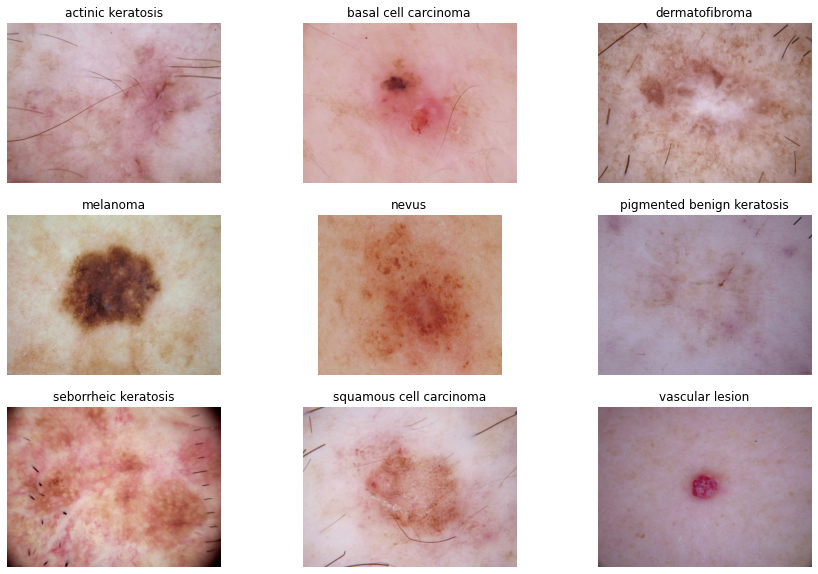

In [8]:
### Visualizing the training data

plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

Check the configuration of gpu and use gpu.

In [8]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Creating CNN Model
### 1. Create the model without augmentation

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [48]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [49]:
num_classes = 9

# Model building - Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense

model = tf.keras.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

#### Compiling the model

In [50]:
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
activation_20 (Activation)   (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
activation_21 (Activation)   (None, 90, 90, 32)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 45, 45, 32)       

#### Training the model

In [52]:
epochs = 50

history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/50
56/56 [==============================] - 19s 78ms/step - loss: 2.1871 - accuracy: 0.2038 - val_loss: 1.8737 - val_accuracy: 0.3758
Epoch 2/50
56/56 [==============================] - 1s 14ms/step - loss: 1.8120 - accuracy: 0.3666 - val_loss: 1.6235 - val_accuracy: 0.4116
Epoch 3/50
56/56 [==============================] - 1s 14ms/step - loss: 1.6366 - accuracy: 0.4183 - val_loss: 1.5197 - val_accuracy: 0.4810
Epoch 4/50
56/56 [==============================] - 1s 16ms/step - loss: 1.4725 - accuracy: 0.5040 - val_loss: 1.3935 - val_accuracy: 0.5481
Epoch 5/50
56/56 [==============================] - 1s 15ms/step - loss: 1.4432 - accuracy: 0.4914 - val_loss: 1.5179 - val_accuracy: 0.4743
Epoch 6/50
56/56 [==============================] - 1s 14ms/step - loss: 1.3689 - accuracy: 0.5233 - val_loss: 1.5423 - val_accuracy: 0.4877
Epoch 7/50
56/56 [==============================] - 1s 15ms/step - loss: 1.1979 - accuracy: 0.5756 - val_loss: 1.3448 - val_accuracy: 0.5548
Epoch 8/50
5

#### Visualizing the results

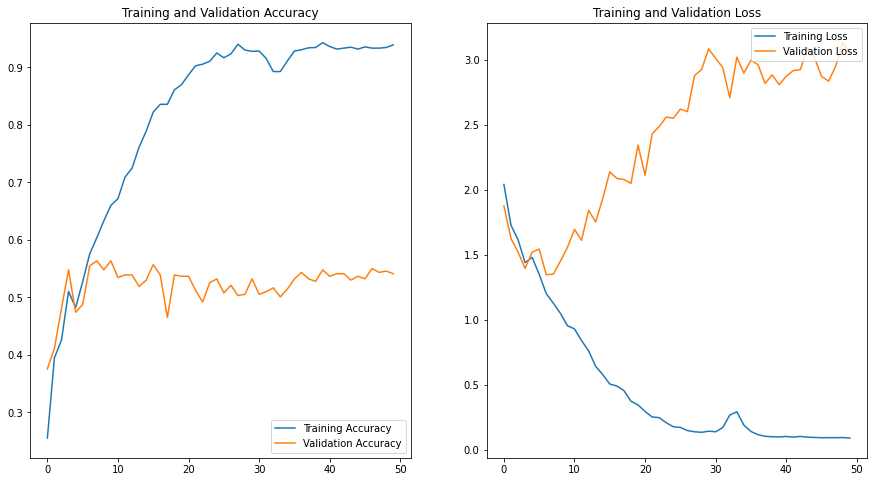

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model is overfitting since the validation loss is much greater than the training loss. also we can see a great difference in accuracy scores. Next we will check for class inbalance and apply data augmentation.

### Class imbalance check.
Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [19]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'actinic keratosis': 114,
 'basal cell carcinoma': 376,
 'dermatofibroma': 95,
 'melanoma': 438,
 'nevus': 357,
 'pigmented benign keratosis': 462,
 'seborrheic keratosis': 77,
 'squamous cell carcinoma': 181,
 'vascular lesion': 139}

In [20]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


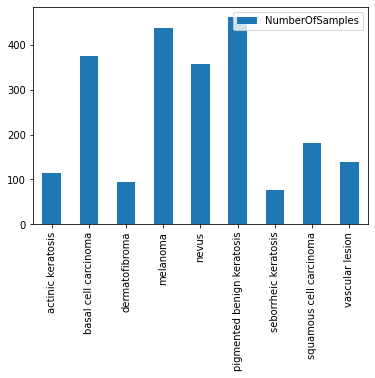

In [21]:
class_df.plot.bar()
plt.show()

### Rectify the class imbalance
 Python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [5]:
!pip install Augmentor

In [6]:
import Augmentor

In [11]:
path_to_training_dataset = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/Augmentation/'+i)
    p.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
    p.sample(2000) # This will make 2000 images for each class

Executing Pipeline:   0%|          | 0/2000 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/Augmentation/actinic keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA396EB6450>: 100%|██████████| 2000/2000 [00:40<00:00, 49.47 Samples/s] 
Executing Pipeline:   0%|          | 0/2000 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /kaggle/working/Augmentation/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA396E2F2D0>: 100%|██████████| 2000/2000 [00:39<00:00, 50.28 Samples/s]                   
Executing Pipeline:   0%|          | 0/2000 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /kaggle/working/Augmentation/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA3971EC550>: 100%|██████████| 2000/2000 [00:41<00:00, 48.37 Samples/s]                   
Executing Pipeline:   0%|          | 0/2000 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /kaggle/working/Augmentation/melanoma.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FA396F83590>: 100%|██████████| 2000/2000 [03:37<00:00,  9.19 Samples/s]                  
Executing Pipeline:   0%|          | 0/2000 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /kaggle/working/Augmentation/nevus.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FA3970C2ED0>: 100%|██████████| 2000/2000 [03:23<00:00,  9.82 Samples/s]                  
Executing Pipeline:   0%|          | 0/2000 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /kaggle/working/Augmentation/pigmented benign keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA397165750>: 100%|██████████| 2000/2000 [00:39<00:00, 50.31 Samples/s]
Executing Pipeline:   0%|          | 0/2000 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /kaggle/working/Augmentation/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA3972D9B90>: 100%|██████████| 2000/2000 [01:33<00:00, 21.32 Samples/s]                  
Executing Pipeline:   0%|          | 0/2000 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /kaggle/working/Augmentation/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA32CD6D610>: 100%|██████████| 2000/2000 [00:40<00:00, 49.87 Samples/s]                  
Executing Pipeline:   0%|          | 0/2000 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /kaggle/working/Augmentation/vascular lesion.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA396F42590>: 100%|██████████| 2000/2000 [00:40<00:00, 49.86 Samples/s] 


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
output_dir = pathlib.Path('/kaggle/working/Augmentation/')

In [28]:
image_count_train = len(list(output_dir.glob('*/*.jpg')))
print(image_count_train)

18000


### 2.Create the model with augmentation
#### Creating new dataset after Augmentation

In [56]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18000 files belonging to 9 classes.
Using 14400 files for training.


In [57]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18000 files belonging to 9 classes.
Using 3600 files for validation.


In [58]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
num_classes = 9

# Model - Rescaling -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

#### Compile your model

In [32]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
activation_4 (Activation)    (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
activation_5 (Activation)    (None, 90, 90, 32)       

#### Train your model

In [33]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
225/225 [==============================] - 29s 39ms/step - loss: 2.6989 - accuracy: 0.1250 - val_loss: 1.7399 - val_accuracy: 0.3328
Epoch 2/30
225/225 [==============================] - 3s 15ms/step - loss: 1.5841 - accuracy: 0.4022 - val_loss: 1.5243 - val_accuracy: 0.4417
Epoch 3/30
225/225 [==============================] - 3s 15ms/step - loss: 1.2892 - accuracy: 0.5244 - val_loss: 1.2793 - val_accuracy: 0.5172
Epoch 4/30
225/225 [==============================] - 3s 15ms/step - loss: 1.1064 - accuracy: 0.6005 - val_loss: 1.1483 - val_accuracy: 0.6022
Epoch 5/30
225/225 [==============================] - 3s 15ms/step - loss: 0.9358 - accuracy: 0.6610 - val_loss: 0.9370 - val_accuracy: 0.6828
Epoch 6/30
225/225 [==============================] - 3s 15ms/step - loss: 0.7708 - accuracy: 0.7160 - val_loss: 0.9279 - val_accuracy: 0.6872
Epoch 7/30
225/225 [==============================] - 3s 15ms/step - loss: 0.6821 - accuracy: 0.7557 - val_loss: 0.8846 - val_accuracy: 0.719

#### Visualize the model results

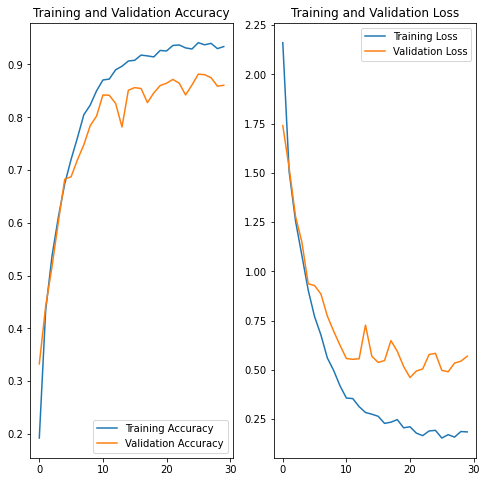

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15
                    , 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

####  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



We still have an overfitting model, but we have much better accuracy than previous models.At end we have around 30% accuracy difference between training and validation data.
Class balance helped us in getting better accuracy.

We can reduce the overfitting by having a deeper model or add a data augmentation layer before it.

### 3. Create the Model with data augmentation and using Augmentor dataset

In [34]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [35]:
num_classes = 9

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense

model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

#### Compile & Train the model

In [36]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 180, 180, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
activation_8 (Activation)    (None, 180, 180, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)       

In [38]:
epochs = 50
# Train the model
history = model.fit(train_ds,validation_data=val_ds,epochs=epochs)

Epoch 1/50
450/450 [==============================] - 59s 127ms/step - loss: 1.8750 - accuracy: 0.3008 - val_loss: 1.3326 - val_accuracy: 0.4892
Epoch 2/50
450/450 [==============================] - 57s 126ms/step - loss: 1.3219 - accuracy: 0.4957 - val_loss: 1.1315 - val_accuracy: 0.5794
Epoch 3/50
450/450 [==============================] - 57s 125ms/step - loss: 1.1585 - accuracy: 0.5644 - val_loss: 0.9889 - val_accuracy: 0.6339
Epoch 4/50
450/450 [==============================] - 57s 126ms/step - loss: 1.0304 - accuracy: 0.6148 - val_loss: 0.9004 - val_accuracy: 0.6714
Epoch 5/50
450/450 [==============================] - 57s 125ms/step - loss: 0.9023 - accuracy: 0.6687 - val_loss: 0.7640 - val_accuracy: 0.7303
Epoch 6/50
450/450 [==============================] - 57s 126ms/step - loss: 0.8256 - accuracy: 0.6945 - val_loss: 0.7198 - val_accuracy: 0.7508
Epoch 7/50
450/450 [==============================] - 57s 125ms/step - loss: 0.7186 - accuracy: 0.7375 - val_loss: 0.5937 - val_ac

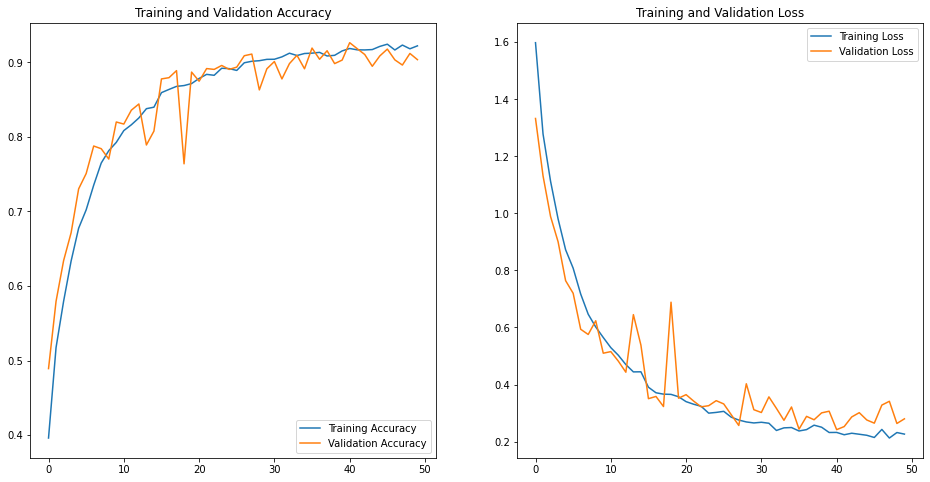

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## Hyperparameter tunning
In this section we will try to obtain improved results by applying RandomSearch hyperparameter tuning.

In [59]:
def model_building(hp):
    model = Sequential([layers.experimental.preprocessing.Rescaling \
                    (1./255,input_shape=(img_height,img_width,3))])
    model.add(Conv2D(hp.Choice('units',[16,32,64]), kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())

    model.add(Conv2D(hp.Choice('units',[32,64]), kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.2))

    model.add(Conv2D(hp.Choice('units',[32,64]), kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D())
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.2))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dense(units=9))
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-1, sampling="log")
    opt = Adam(learning_rate = lr)
    model.compile(optimizer= opt,
              loss= SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

model_building(keras_tuner.HyperParameters())
# model.summary()

In [60]:
epochs = 50
callback = EarlyStopping(
    monitor="val_loss", 
    patience=5,
    verbose=1,
    baseline=None,
    restore_best_weights=True)

tuner = keras_tuner.RandomSearch(
    model_building,
    objective='val_accuracy',
    max_trials=40,seed=111)

tuner.search(x=train_ds,
                    validation_data=val_ds,
                    epochs=epochs
                    ,verbose=1,callbacks=[callback])
models = tuner.get_best_models(2)

Trial 40 Complete [00h 02m 22s]
val_accuracy: 0.11444444209337234

Best val_accuracy So Far: 0.9027777910232544
Total elapsed time: 01h 27m 23s


We will select the best model here.

In [61]:
best_model = models[0]
best_model

## Model evaluation

In [66]:
path_to_test_dataset = '../input/skin-cancer9-classesisic/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'
test_dataset = image_dataset_from_directory(path_to_test_dataset, image_size=(img_height, img_width), 
                                           batch_size=batch_size)

Found 118 files belonging to 9 classes.


Predictions:
 [1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 1 0 0 0 0
 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1
 1 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 0
 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1
 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 0
 1 0 1 1 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 0 1
 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 1 1 0
 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0]
Labels:
 [0 5 2 8 3 3 3 1 1 4 0 1 3 7 2 8 7 3 0 2 1 1 2 4 7 2 5 3 7 1 1 7]


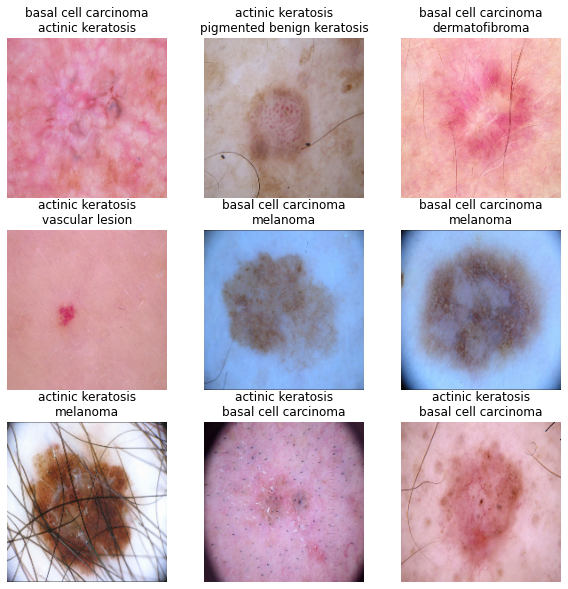

In [67]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = best_model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")

In [68]:
(eval_loss, eval_accuracy) = best_model.evaluate(test_dataset, batch_size=batch_size, \
                                            verbose=1)

4/4 [==============================] - 5s 58ms/step - loss: 5.7989 - accuracy: 0.4419


The model accuracy is 44% which is not good unfortunatly....

In [64]:
best_model.save('MlFlow.h5')

In [69]:
best_model.save_weights('MlFlow_mdl_weights.h5')

## Results & Conclusions

The model performed poorly on the evaluation test, we think that it's because the model is still overfitting and the Data Augmentation is not enough, We need more images , more data to address this issue.

This project is the Capstone project for our internship from HamoyeAI.